<a href="https://colab.research.google.com/github/gabrielfraga17/IA-Generativa/blob/main/AKCIT_GenAI_M10_Colab_Unidade_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

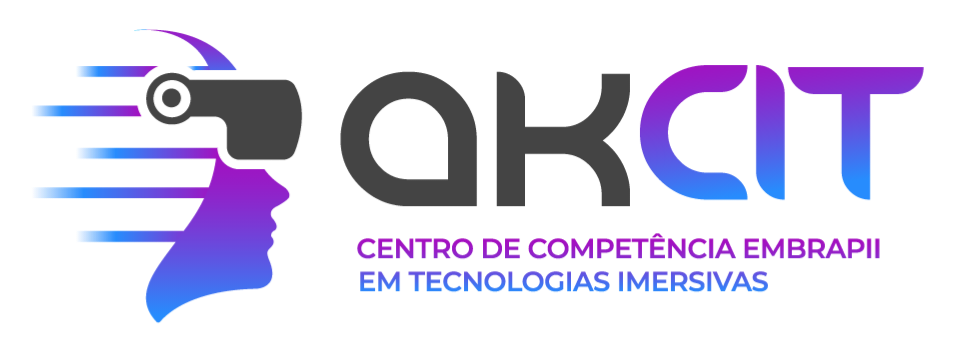


# Identificação

**Microcurso:** Arquiteturas neurais avançadas para IA generativa para visão computacional


**Docente:** M.Sc. Leon Sólon da Silva

## 🎯 Objetivos de Aprendizagem

Ao final desta unidade, o estudante será capaz de:

1. Explicar o funcionamento de uma **GAN** como jogo entre Gerador e Discriminador.  
2. Implementar uma **Deep Convolutional GAN (DCGAN)** em PyTorch.  
3. Treinar a GAN em um dataset de rostos (CelebA) e gerar amostras sintéticas.  
4. Avaliar qualitativamente os resultados (originais vs gerados).  
5. Compreender desafios de estabilidade e colapso de modos no treinamento de GANs.  


## 📚 Introdução

Nas unidades anteriores, trabalhamos com Autoencoders e VAEs, que organizam representações latentes e permitem gerar novas instâncias.  
Agora avançamos para um novo paradigma: as **Redes Generativas Adversárias (GANs)**.  

A ideia central é colocar **duas redes neurais em competição**:
- O **Gerador (G)** tenta criar imagens falsas convincentes.  
- O **Discriminador (D)** tenta distinguir entre imagens reais e falsas.  

Esse jogo de soma zero (minimax) leva ambos a melhorar continuamente, resultando em amostras cada vez mais realistas.  
GANs se tornaram marcos na IA generativa por sua capacidade de produzir imagens de alta fidelidade, especialmente rostos.  


## 🧠 Explicação Teórica

- **Gerador (G):** recebe um vetor de ruído aleatório como entrada e aprende a transformá-lo em uma imagem plausível.  
- **Discriminador (D):** recebe imagens reais e falsas, aprendendo a classificá-las corretamente.  
- **Treinamento adversarial:** G e D são treinados alternadamente; G busca enganar D, enquanto D busca não ser enganado.  
- **Função objetivo (minimax):**  
  - D maximiza sua acurácia em distinguir real/falso.  
  - G minimiza a capacidade de D em detectá-lo.  

Arquiteturas como **DCGAN** usam convoluções profundas para estabilizar o treinamento, e variantes como **WGAN** melhoram a função de perda para reduzir problemas como **mode collapse**.  


## 💻 Exemplos Práticos

Neste notebook, implementaremos uma **DCGAN** em PyTorch utilizando o dataset **CelebA**:

1. Carregar e pré-processar o dataset de rostos.  
2. Implementar o **Gerador** e o **Discriminador** usando convoluções.  
3. Definir função de perda (BCE) e otimizadores (Adam).  
4. Treinar o modelo em GPU por algumas épocas.  
5. Visualizar amostras geradas ao longo do treinamento.  


## 📝 Exercícios e Desafios

1. Alterar o tamanho do vetor de ruído (`nz`) e observar impacto na diversidade das imagens.  
2. Aumentar o número de épocas para gerar rostos mais nítidos.  
3. Implementar uma **Conditional GAN (cGAN)** para gerar rostos com atributos específicos (ex: sorridente, com óculos).  
4. Experimentar variantes como **WGAN** ou **LSGAN** e comparar a estabilidade do treinamento.  


## 📖 Referências Bibliográficas

- GOODFELLOW, I. et al. *Generative Adversarial Nets*. NeurIPS, 2014.  
- GOODFELLOW, I.; BENGIO, Y.; COURVILLE, A. *Deep Learning*. MIT Press, 2016.  
- RADFORD, A.; METZ, L.; CHINTALA, S. *Unsupervised Representation Learning with DCGAN*. ICLR, 2016.  
- ARJOVSKY, M.; CHINTALA, S.; BOTTOU, L. *Wasserstein GAN*. arXiv:1701.07875, 2017.  
- CRESWELL, A. et al. *Generative Adversarial Networks: An Overview*. IEEE Signal Processing Magazine, 2018.  
- KARRAS, T.; LAINE, S.; AILA, T. *A Style-Based Generator Architecture for Generative Adversarial Networks (StyleGAN)*. CVPR, 2019.  


### 📦 Preparação do ambiente
Nesta célula importamos bibliotecas essenciais:
- **PyTorch (`torch`, `nn`, `optim`)**: para definir o modelo e treinar a GAN.  
- **Torchvision**: fornece datasets (CelebA) e utilitários de pré-processamento.  
- **Matplotlib**: usado para visualizar imagens geradas e reais.  

Também configuramos o dispositivo para usar GPU se disponível — importante, pois treinar GANs em CPU é impraticável.


In [ ]:
# ======================================================
# GAN com CelebA (DCGAN 64x64)
# ======================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


### 📂 Carregando o dataset CelebA
O **CelebA** é um dos datasets mais usados em GANs, com mais de 200 mil imagens de rostos de celebridades.  

- Aqui reduzimos as imagens para **64×64** pixels (resolução típica de DCGANs).  
- As normalizamos para o intervalo `[-1,1]`, compatível com a saída `Tanh` do gerador.  
- Usamos `DataLoader` para carregar mini-batches de forma eficiente durante o treino.  


In [ ]:
# ----------------------------
# 1. Dataset CelebA
# ----------------------------

transform = transforms.Compose([
    transforms.Resize(64),      # reduz para 64x64
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normaliza em [-1,1]
])

dataset = torchvision.datasets.CelebA(root="./data", split="train", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

print("Total de imagens:", len(dataset))


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=8490c257-cd10-45ef-8b0d-a6226495b195
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:26<00:00, 54.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 54.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 47.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 20.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landm

Total de imagens: 162770


### 🧠 O Gerador
O **Gerador (G)** recebe como entrada um vetor de ruído aleatório (100 dimensões) e produz imagens falsas **64×64×3**.  

- Usamos `ConvTranspose2d` para aumentar a resolução gradualmente.  
- Camadas `BatchNorm2d` ajudam na estabilidade do treinamento.  
- A ativação final é `Tanh`, que gera pixels normalizados em `[-1,1]`.  

O objetivo do Gerador é criar imagens que o **Discriminador** confunda com reais.


In [ ]:
# ----------------------------
# 2. Definir o Gerador
# ----------------------------

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), # 4x4 -> 8x8
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), # 8x8 -> 16x16
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),   # 16x16 -> 32x32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),      # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator().to(device)


### 🕵️ O Discriminador
O **Discriminador (D)** é uma CNN que recebe uma imagem (real ou gerada) e retorna uma probabilidade de ser **real**.  

- Estrutura: camadas `Conv2d` com `LeakyReLU` (não linearidade suave).  
- `BatchNorm2d` ajuda a normalizar os gradientes e estabilizar o treino.  
- Saída final é um único valor (via `Sigmoid`).  

O objetivo do Discriminador é **acertar a classificação**: real vs falso.


In [ ]:
# ----------------------------
# 3. Definir o Discriminador
# ----------------------------

class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), # 32x32 -> 16x16
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), # 16x16 -> 8x8
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False), # 8x8 -> 4x4
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),    # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

netD = Discriminator().to(device)


### ⚙️ Função de perda e otimizadores
- Usamos **Binary Cross Entropy (BCE)**: mede a diferença entre as predições do discriminador e os rótulos (1 = real, 0 = falso).  
- Otimizadores: **Adam** com taxa de aprendizado baixa e `betas` ajustados (0.5, 0.999), recomendados no paper **DCGAN** para estabilidade.  
- Criamos também um vetor fixo de ruído (`fixed_noise`) para gerar imagens ao longo do treinamento e observar a evolução do Gerador.  


In [ ]:
# ----------------------------
# 4. Função de perda e otimizadores
# ----------------------------

criterion = nn.BCELoss()

# Vetor fixo de ruído para acompanhar progresso
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Otimizadores
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


### 🎮 Treinamento adversarial
O treinamento segue o **jogo minimax**:

1. **Atualiza D (Discriminador):**  
   - Recebe imagens reais (rótulo = 1).  
   - Recebe imagens falsas do Gerador (rótulo = 0).  
   - Ajusta pesos para melhorar a separação real/falso.  

2. **Atualiza G (Gerador):**  
   - Gera novas imagens.  
   - Passa pelo Discriminador, mas agora os rótulos são forçados como **1**.  
   - O objetivo do Gerador é enganar o Discriminador.  

Essa dinâmica cria a **competição adversarial**, onde ambos melhoram juntos.


In [ ]:
# ----------------------------
# 5. Loop de treinamento
# ----------------------------

num_epochs = 5  # pode aumentar no Colab Pro
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Atualizar D
        ############################
        netD.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), 1., device=device)
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Atualizar G
        ############################
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}")


[1/5] Loss_D: 0.5140 Loss_G: 2.9166
[2/5] Loss_D: 0.5804 Loss_G: 1.0152
[3/5] Loss_D: 1.2155 Loss_G: 0.8587
[4/5] Loss_D: 1.0808 Loss_G: 2.9429
[5/5] Loss_D: 0.3581 Loss_G: 1.4470


### 🖼️ Resultados
Após algumas épocas, podemos visualizar imagens geradas pelo **Gerador**.  

- Cada amostra começa como ruído puro, mas o treinamento adversarial faz com que gradualmente se aproximem de rostos plausíveis.  
- A qualidade melhora quanto mais tempo treinamos.  
- Com poucas épocas no Colab, os rostos ainda podem parecer borrados ou distorcidos, mas já capturam formas e tons de pele.  


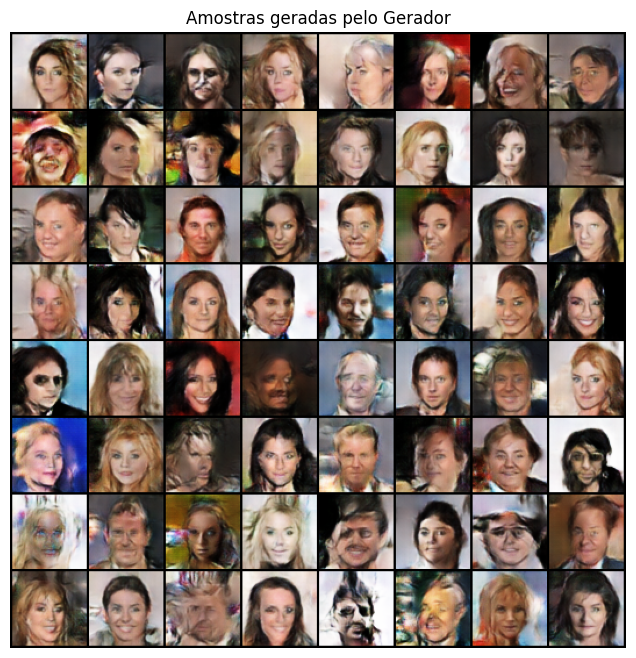

In [ ]:
# ----------------------------
# 6. Visualização
# ----------------------------

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()

# Plotar imagens falsas
grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title("Amostras geradas pelo Gerador")
plt.axis("off")
plt.show()


## 📝 Exercício
1. Gere imagens com o modelo em diferentes momentos do treinamento (ex.: após 1, 5 e 20 épocas).  
2. Compare visualmente a nitidez e a diversidade das imagens ao longo do tempo.  
3. Registre suas observações em texto ou imagens salvas.

> Pergunta: como a qualidade das imagens evolui durante o treinamento do GAN?

---

## 🚀 Desafio
1. Modifique a arquitetura do **gerador** ou do **discriminador** (ex.: troque ReLU por LeakyReLU, altere normalização, ou o número de filtros).  
2. Experimente diferentes otimizadores ou funções de perda (ex.: RMSprop em vez de Adam, ou hinge loss).  
3. Treine novamente e compare com o modelo original.

> Perguntas:
- Como essas mudanças impactaram a estabilidade do treinamento?  
- Você observou *mode collapse* (o gerador repetindo sempre o mesmo tipo de imagem)?  
- As imagens ficaram mais nítidas ou mais instáveis?


## ✅ Conclusão
Nesta prática implementamos uma **DCGAN (Deep Convolutional GAN)** em PyTorch, aplicada ao dataset **CelebA**:

- O **Gerador** aprendeu a criar rostos sintéticos a partir de vetores de ruído.  
- O **Discriminador** foi treinado para distinguir rostos reais de falsos.  
- O jogo adversarial levou ambos a melhorar em conjunto.  

➡️ Próximos passos sugeridos:
1. Aumentar o número de épocas (20+).  
2. Experimentar com diferentes tamanhos de vetor de ruído (`nz`).  
3. Adaptar para uma **Conditional GAN (cGAN)**, onde o modelo gera rostos com atributos específicos (ex: sorridente, óculos, etc.).  
4. Explorar variantes mais estáveis, como **WGAN-GP**.  

Com isso, você fecha a Unidade III com um exemplo prático de GANs aplicado a **rostos humanos**, conectando teoria e prática.
